# Rate vs Cross section

In general we can write the relation between Rate, $\frac{dR}{d\Omega}$, and the Cross Section, $\frac{d\sigma}{d\Omega}$: 

$$
\frac{dR}{d\Omega} = \epsilon_{spettrometer}(\theta) \frac{n_{gate}}{T} n_c \wp(\theta; \lambda, \lambda') \frac{d\sigma}{d\Omega}
$$
 
where $n_{gate}$ is the number of photons that open the gate and $n_e$ is the density of scattering centers. 

## Geometry parameters

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

r_gate = 1.27  #cm
d_gate_source = 16 #cm
d_sorg_targ = 5 #cm
target_width = 1 #cm 
beta_2 = np.arctan(r_gate / d_gate_source)
r = d_sorg_targ * np.tan(beta_2)
Omega = 2 * np.pi * (1 - np.cos(beta_2)) #sr

## Physical parameters

In [ ]:
r_e = 2.817e-13  # Classical electron radius in cm
m_e = 511  # Electron rest mass energy in keV
alpha = 1 / 137  # Fine-structure constant (dimensionless)
N_a = 6.022e23 # mol^(-1)

## Calculus of the density of scattering center
We can think that at first approximation, $n_c$ is the number of electrons in the illuminated region of the target, and so it follow the following equation:
$$
n_c = \rho \frac{N_aZ}{\text{MM}}
$$
where: 
- $\rho$ is the density of the scattering target
- $N_a$ is the Avogadro number
- $\text{MM}$ is the molar mass of the scattering target
- $Z$ is the atomic number

In [ ]:
#For a Cu target
rho = 8.96 #g/cm^3
Z = 29 #number of electrons
MM = 63.546 #g/mol

n_c = rho * (N_a / MM) 
print(n_c)

8.491033267239482e+22


## Calculus of the number of photons that open the gate
We can think at the number of photons that open the gate as: 

$$
n_{gate} = \frac{2 S(t) T\text{BR}}{T}\frac{\Delta\Omega}{4\pi}\epsilon_{gate}(511) = 2 S(t) \text{BR}\frac{\Delta\Omega}{4\pi}\epsilon_{gate}(511)
$$

where: 
- $S(t)$ is the activity of the source in Bq
- $\text{BR}$ is the branching ratio of the 511 keV photon
- $T$ is the time of the measurment
- $\frac{\Delta\Omega}{4\pi}$ is the solid angle
- $\epsilon_{gate}(511)$ is the efficiency of the gate detector for the 511 keV photon

In [ ]:
S = 175000 #Bq
BR = 0.903
epsilon_gate = 0.17

flux = (2 * S * BR) * (Omega / (4 * np.pi)) * epsilon_gate #s^-1
print(flux)

84.22983210325951


# Calculus of the probability factor

We can write $\wp(\theta; \lambda, \lambda')$ as: 
$$
\wp(\theta; \lambda, \lambda') = \lambda'' (1-e^{-\frac{D'}{\lambda''}})
$$

where: 
- $D' = \frac{D}{\cos(\frac{\pi - \theta}{2})}$ and $D$ is the target width
- $\lambda'' = \frac{\lambda\lambda'}{\lambda'-\lambda}$
- $\lambda$ is the mean free path for a 511 keV photon 
- $\lambda'$ is the mean free path for the photon after the scattering


### Cross section calculus

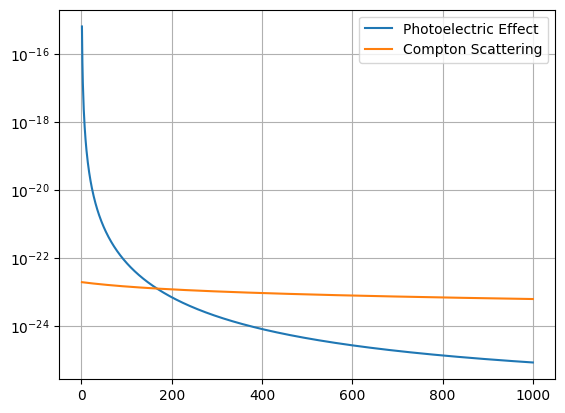

In [ ]:
def cross_section_thomson():
    """
    Calculate the Thomson cross-section, which represents the scattering 
    of electromagnetic waves by free electrons at low photon energies.

    :return: Thomson cross-section in square meters.
    """
    return (8 / 3) * np.pi * r_e ** 2


def cross_section_photoelectric(energy: float, Z: float) -> float:
    """
    Calculate the photoelectric cross-section for a photon interacting with a material.

    :param photon: Photon object containing energy information (energy in MeV).
    :param Z: Atomic number of the material.
    :return: Photoelectric cross-section in square meters.
    """
    bond_energy = 0.0047  # Example binding energy in keV
    gamma = (energy + m_e - bond_energy) / m_e 
    c = (3 / 2) * (alpha ** 4) * cross_section_thomson()  # Coefficient based on fine-structure constant

    return c * (
        ((Z * m_e / energy) ** 5) *
        (gamma ** 2 - 1) ** (3/2) *
        (
            (4/3) + (gamma * (gamma - 2) / (gamma + 1)) *
            (
                1 - (1 / (2 * gamma * (gamma ** 2 - 1)**(1/2))) *
                np.log((gamma + (gamma ** 2 - 1)**(1/2)) / (gamma - (gamma ** 2 - 1)**(1/2)))
            )
        )
    )


def cross_section_compton(energy: float, Z: float) -> float:
    """
    Calculate the Compton scattering cross-section for a photon interacting with a material.

    :param photon: Photon object containing energy information (energy in MeV).
    :param Z: Atomic number of the material.
    :return: Compton cross-section in square meters.
    """
    epsilon = energy / m_e  # Ratio of photon energy to electron rest mass energy

    # Define calculations for high and low energy regimes
    # These calculations are already vectorized if epsilon is an array
    
    # High energy part
    c_high = 2 * np.pi * r_e ** 2  # Coefficient based on Thomson cross-section
    # Handle potential division by zero if epsilon can be zero or very small.
    # For energy > 100 MeV, epsilon is large.
    term1_high = (1 + epsilon) / epsilon ** 2
    term2_high = (2 * (1 + epsilon) / (1 + 2 * epsilon)) - (np.log(1 + 2 * epsilon) / epsilon)
    term3_high = np.log(1 + 2 * epsilon) / (2 * epsilon)
    term4_high = (1 + 3 * epsilon) / (1 + 2 * epsilon) ** 2
    result_high = c_high * Z * (term1_high * term2_high + term3_high - term4_high)

    # Low energy part
    c_low = cross_section_thomson() 
    poly_term = (
        1 + 2 * epsilon + (6/5) * epsilon ** 2 - (1/2) * epsilon ** 3 +
        (2/7) * epsilon ** 4 - (6/35) * epsilon ** 5 + (8/105) * epsilon ** 6 + (4/105) * epsilon ** 7
    )
    result_low = c_low * Z * (1 / (1 + 2 * epsilon) ** 2) * poly_term
    
    # Use np.where to choose between high and low energy calculations
    return np.where(energy > 100, result_high, result_low)

energies = np.linspace(1, 1000, 1000)  
plt.plot(energies, cross_section_photoelectric(energies, Z), label='Photoelectric Effect')
plt.plot(energies, cross_section_compton(energies, Z), label='Compton Scattering')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

### $\lambda$ calculus
$$
\lambda = \frac{1}{n_c\sigma_{tot}}
$$

In [ ]:
def attenuation_factor(total_cross_section: float, density_of_scattering_centers: float) -> float:
    """
    Calculate the attenuation factor for a photon traveling through a material.

    :param total_cross_section: Total cross-section for the interaction (in cm²).
    :param scattering_target: Material properties (e.g., density, molar mass).
    :return: Attenuation factor (inverse mean free path).
    """
    return total_cross_section * density_of_scattering_centers # cm^-1

def attenuation_length(attenuation_factor: float) -> float:
    """
    Calculate the attenuation length for a photon traveling through a material.

    :param attenuation_factor: Attenuation factor (inverse mean free path).
    :return: Attenuation length in cm.
    """
    return 1 / attenuation_factor  # cm


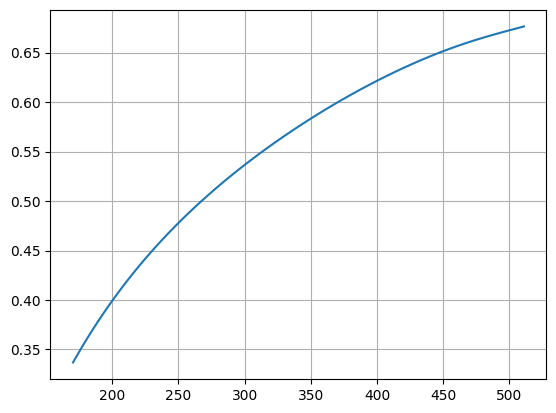

In [200]:
def compton_scattering(theta):
    return 511 / (2 - np.cos(theta))

def prob(theta):
    D_prime = target_width / np.cos((np.pi - theta)/2)
    E = 511
    E_prime = compton_scattering(theta)
    lam = attenuation_length(attenuation_factor(cross_section_compton(E, Z) + cross_section_photoelectric(E, Z), rho * (N_a / MM)))
    lam_prime = attenuation_length(attenuation_factor(cross_section_compton(E_prime, Z) + cross_section_photoelectric(E_prime, Z), rho * (N_a / MM)))
    lam_dubprime = (lam * lam_prime) / (lam_prime + lam)
    
    return lam_dubprime * (1 - np.exp(-D_prime / lam_dubprime))

thetas = np.linspace(0, np.pi, 100)
plt.plot(compton_scattering(thetas), prob(thetas))
plt.grid()
plt.show()

### NIST data

Parametri del fit:
<ValueView a=1.9558540418792372 b=-0.576270873044174>
Errori:
<ErrorView a=0.011918526979641013 b=0.007998806594711395>


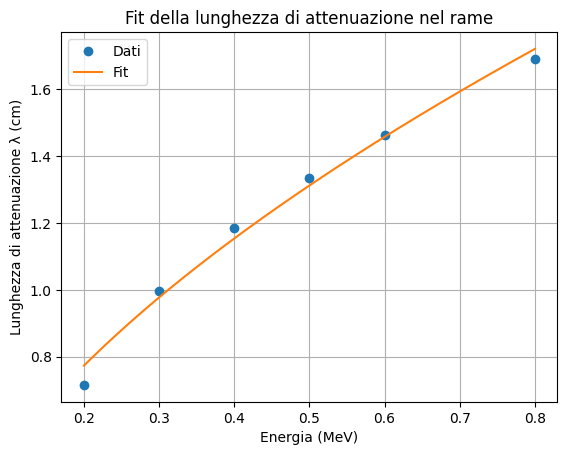

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import LeastSquares

# Dati (energia in MeV, mu/rho in cm^2/g)
energy = np.array([
    0.2, 0.3, 0.4, 0.5, 0.6,
    0.8])
mu_over_rho = np.array([
    0.1559, 0.1119, 0.09413, 0.08362, 0.07625,
    0.06605
])

# Costante: densità rame
rho = 8.96  # g/cm^3

# Calcolo mu e lambda
mu = mu_over_rho * rho
lambda_cm = 1 / mu

# Funzione da fittare: ad esempio, tipo potenza inversa
def model(E, a, b):
    return a * E**(-b)

# Least squares
least_squares = LeastSquares(energy, lambda_cm, np.full_like(lambda_cm, 0.01), model)

# Fit con iminuit
m = Minuit(least_squares, a=1.0, b=1.0)
m.migrad()

# Stampa risultati
print("Parametri del fit:")
print(m.values)
print("Errori:")
print(m.errors)

# Grafico
E_plot = np.linspace(min(energy), max(energy), 300)
plt.plot(energy, lambda_cm, 'o', label="Dati")
plt.plot(E_plot, model(E_plot, *m.values), '-', label="Fit")
plt.xlabel("Energia (MeV)")
plt.ylabel("Lunghezza di attenuazione λ (cm)")
plt.title("Fit della lunghezza di attenuazione nel rame")
plt.legend()
plt.grid()
plt.show()


## Calculus of the efficiency

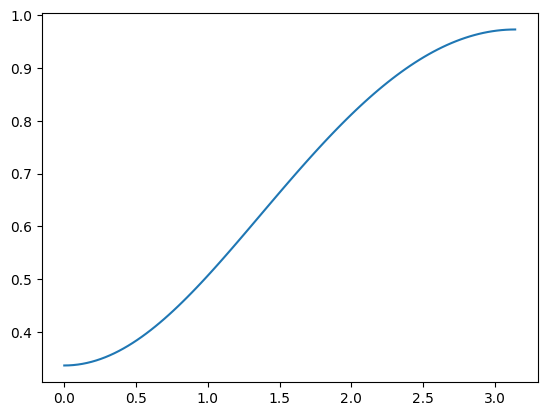

In [ ]:
def epsilon_spettrometer(theta): 
    A = 0.42719
    B = 0.58613
    C = 1.69372
    D = 0.07002

    E  = compton_scattering(theta) * 1e-3 #MeV

    return A * pow(E, -B) * np.exp(-C * E) + D

plt.plot(thetas, epsilon_spettrometer(thetas))
plt.show()

## Total correction 

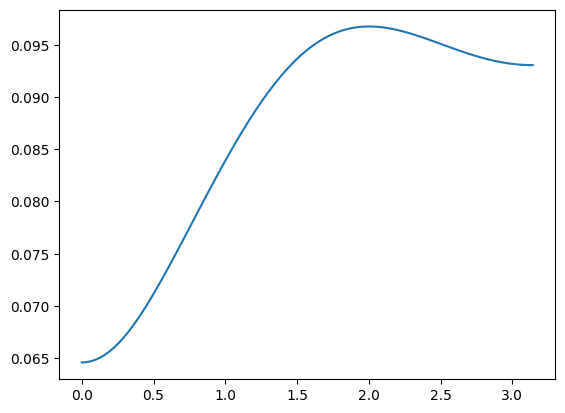

In [ ]:
def const (theta):
    return (r_e ** 2 / 2) * n_c * flux * prob(theta) * epsilon_spettrometer(theta)

plt.plot(thetas, const(thetas))
plt.show()

## Klein-Nishina
$$
\frac{d\sigma}{d\Omega} = \frac{r_e^2}{2}\bigg(\frac{\omega'}{\omega}\bigg)^2\bigg[\frac{\omega'}{\omega} + \frac{\omega}{\omega'} - \sin^2(\theta)\bigg]
$$


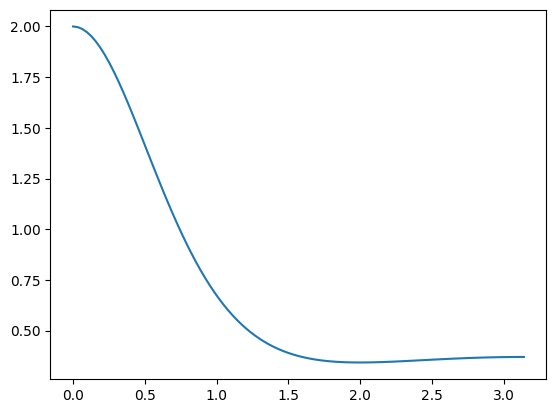

In [ ]:
def klein_nishina(theta):
    E = compton_scattering(theta)
    r = E / 511
    return r ** 2 * (r + 1/r - np.sin(theta) ** 2)

plt.plot(thetas, klein_nishina(thetas))
plt.show()

## Complete Klein-Nishina (with correction)

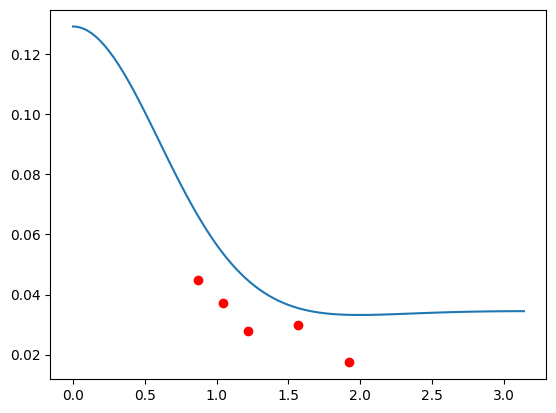

In [ ]:
def rate_function(theta):
    return const(theta) * klein_nishina(theta)

angles = np.array([ 50, 60, 70, 90, 110]) * np.pi / 180
measured_rates = np.array([ 0.0448, 0.03729, 0.0280, 0.03001, 0.01740])

plt.plot(thetas, rate_function(thetas))
plt.scatter(angles, measured_rates, color='red')
plt.show()

┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │ 25.99e-27 │ 0.14e-27  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
Chi2: 852.60, NDF: 4.0


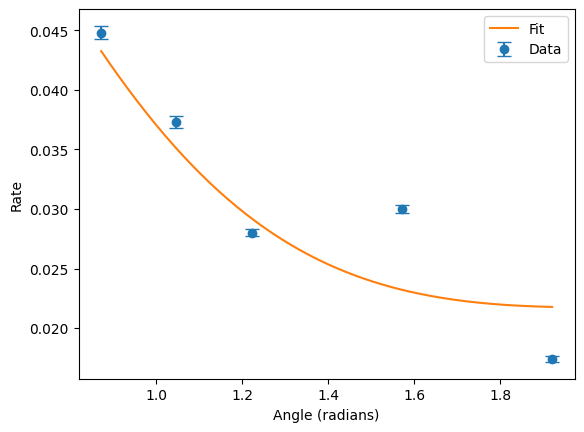

Fitted value of a: 2.599168452281571e-26
r_e (true) : 2.817e-13
r_e (fitted) :2.279986163239405e-13


In [ ]:
from iminuit import Minuit
from iminuit.cost import LeastSquares

def errors(rate_errors, counts_errors, times):
    errors = []
    for i in range(len(rate_errors)):
        # Calculate the error for each rate
        rate_error = rate_errors[i]
        counts_error = counts_errors[i]
        time = times[i]

        error = np.sqrt((counts_error / time) ** 2 + (rate_error) ** 2)
        errors.append(error)
    return errors

angles = np.array([ 50, 60, 70, 90, 110]) * np.pi / 180
measured_rates = np.array([ 0.0448, 0.03729, 0.0280, 0.03001, 0.01740])
measured_fit_errors = np.array([ 0.0004, 0.00035, 0.0002, 0.00022, 0.00017])
measured_counts_errors = np.sqrt(np.array([ 13371, 11165, 19239, 17892, 10994]))
measured_times = np.array([ 43000 * 6 + 40184, 43000 * 6 + 31193 + 10254, 16 * 43000, 43000 * 13 + 37225, 43000 * 14 + 29739])
measured_errors = errors(measured_fit_errors, measured_counts_errors, measured_times)

def fit_function(theta, a):
    return klein_nishina(theta) * flux * n_c * prob(theta) * epsilon_spettrometer(theta) * a

# Create a LeastSquares object
# The independent variable for fit_function is theta, which corresponds to 'angles'
# The dependent variable is 'measured_rates'
# The error on the dependent variable is 'measured_errors'
least_squares = LeastSquares(angles, measured_rates, measured_errors, fit_function)

# Create a Minuit object
# 'a' is the parameter to be fitted. We need to give it an initial guess.
# Let's assume 'a' is a scaling factor, perhaps close to 1 if the model is good,
# or related to the factor of 6 discrepancy noted earlier.
# If the model is ~6 times too large, 'a' might be around 1/6.
# Let's start with an initial guess of 1.0 for 'a'.
m = Minuit(least_squares, a=1.0)

# Perform the minimization
m.migrad()

# Print the fit results
print(m.params)
print(f"Chi2: {m.fval:.2f}, NDF: {m.ndof}") # NDF = Number of data points - Number of fitted parameters

# You can also plot the fit result
plt.errorbar(angles, measured_rates, yerr=measured_errors, fmt="o", label="Data", capsize=5)
fit_theta_fine = np.linspace(min(angles), max(angles), 200)

# Get the fitted value of 'a'
a_fit = m.values["a"]

plt.plot(fit_theta_fine, fit_function(fit_theta_fine, a_fit), label="Fit")
plt.xlabel("Angle (radians)")
plt.ylabel("Rate")
plt.legend()
plt.show()

# To investigate the factor of 6, check the value of a_fit
print(f"Fitted value of a: {a_fit}")
if 'a' in m.errors:
    print(f"Error on a: {m.errors['a']}")

print("r_e (true) :", r_e)
print(f"r_e (fitted) :{np.sqrt(2 * a_fit)}")


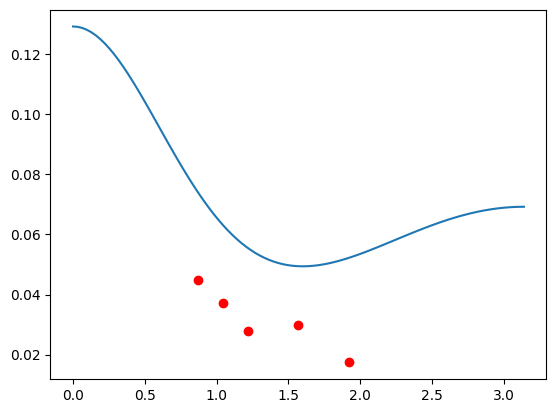

In [208]:
def rate_function(theta):
    E = 511
    
    lam = attenuation_length(attenuation_factor(cross_section_compton(E, Z) + cross_section_photoelectric(E, Z), n_c))
    D_prime = target_width / np.cos((np.pi - theta)/2)
    return (r_e ** 2 / 2) * n_c * flux * (lam/2) * epsilon_spettrometer(theta) * klein_nishina(theta)

plt.plot(thetas, rate_function(thetas))
plt.scatter(angles, measured_rates, color='red')
plt.show()